In [1]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="XEglZlWHI72CqIq1hcr3RSw7j", project_name="GAN", workspace="kraing")

# Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Dataset
import keras.datasets as ds

# Unconditional GAN
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, UpSampling2D

# Conditional GAN
from keras.models import Model
from keras.layers import Input, Embedding, Concatenate

# Visualization tools
from IPython.display import clear_output, Image
import time

COMET INFO: old comet version (3.1.14) detected. current: 3.1.15 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kraing/gan/c733b9c7901c42839b98b1daf45a647e

Using TensorFlow backend.


In [2]:
# Load selected dataset
def load_dataset(dataset):

    if dataset == 'MNIST':
        (trainX, trainy), (_, _) = ds.mnist.load_data()

    if dataset == 'Fashion-MNIST':
        (trainX, trainy), (_, _) = ds.fashion_mnist.load_data()

    # Exapnd to 3D adding one channel
    X = np.expand_dims(trainX, axis=-1)

    # Convert from int to float and rescale from [0, 255] to [-1, 1]
    X = X.astype('float32')
    X = (X - (255 / 2)) / (255 / 2)
    #X = X / 255.
    return [X, trainy]



# Build Discriminator
def build_discriminator(input_shape):

    # Initialize the NN
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(128, 3, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))

    # Second convolutional layer
    model.add(Conv2D(256, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    '''
    # Second convolutional layer
    model.add(Conv2D(512, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    '''
    
    # Flattening and output layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model



# Build Generator with default latent_space=100
def build_generator(latent_dim=100):

    # Initialize the NN
    model = Sequential()

    # Fully connected layer
    model.add(Dense(7 * 7 * 256, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(Dropout(0.4))

    # First upsampling layer 14x14
    model.add(UpSampling2D())
    model.add(Conv2D(256, 3, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    # Second upsampling layer 28x28
    model.add(UpSampling2D())
    model.add(Conv2D(128, 3, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    '''
    # Second upsampling layer 28x28
    model.add(Conv2D(64, 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    '''
    
    # Output layer
    model.add(Conv2D(1, 3, activation='tanh', padding='same'))
    return model



# Build the GAN framework
def build_gan(D, G, input_shape, latent_dim):

    opt = Adam(lr=0.0002, beta_1=0.5)

    # Freeze discriminator weights during generator training
    D.trainable = False
    #D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Connect generator and discriminator
    GAN = Sequential()
    GAN.add(G)
    GAN.add(D)
    GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return GAN

In [6]:
def gen_real(dataset, batch_size):
    X = dataset[np.random.randint(0, dataset.shape[0], size=batch_size), :, :, :]
    y = np.ones((batch_size, 1))
    return X, y


def gen_fake(G, latent_dim, batch_size):
    z = np.random.randn(latent_dim * batch_size)
    z = z.reshape(batch_size, latent_dim)
    X = G.predict(z)
    y = np.zeros((batch_size, 1))
    return X, y


def save_plot(G, noise, epoch):
    # Plot generator prediction on sample_noise
    images = G.predict(noise)
    plt.figure(figsize=(10,10))
        
    for im in range(images.shape[0]):
        plt.subplot(4, 4, im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])
            
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(f'Output/MNIST-D/{epoch}.png')
    plt.close('all')
    
    
def save_model(epoch, G, D, name):
    
    # save the generator model tile file
    filename = f'Model/{name}/G_{epoch + 1}.h5'
    G.save(filename)
    
    # save the generator model tile file
    filename = f'Model/{name}/D_{epoch + 1}.h5'
    G.save(filename)

    
# Train the GAN
def train(D, G, GAN, dataset, name, latent_dim=100, epochs=20, batch_size=128):
    
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    sample_noise = np.random.randn(latent_dim * 16).reshape(16, latent_dim)
    
    D_loss = []
    D_acc_r = []
    D_acc_f = []
    
    G_loss = []
    G_acc = []
    
    etime = []
    

    # Loop over epochs
    for epoch in range(epochs):
        
        save_plot(G, sample_noise, epoch)
        
        start_t = time.time()
        
        eD_loss = []
        eD_acc_r = []
        eD_acc_f = []
        
        eG_loss = []
        eG_acc = []
        
        for mbatch in range(batch_per_epoch):

            # Random select half_batch real samples
            realX, realY = gen_real(dataset, half_batch)
            
            # Random generate half_batch fake samples
            fakeX, fakeY = gen_fake(G, latent_dim, half_batch)
            
            '''
            # Stacks all samples together and train the discriminator ---> should be faster
            #X, y = np.vstack((realX, fakeX)), np.vstack((realY, fakeY))
            #D_stats = D.train_on_batch(X, y)
            '''
            
            # Train the discriminator on the real batch, and generated batch
            D_stats_real = D.train_on_batch(realX, realY)
            D_stats_fake = D.train_on_batch(fakeX, fakeY)
            
            # Generate random noise and labels to train the Generator
            Z_gan = np.random.randn(latent_dim * batch_size).reshape(batch_size, latent_dim)
            y_gan = np.ones((batch_size, 1))
            G_stats = GAN.train_on_batch(Z_gan, y_gan)
            
            # Save batch parameters
            eD_loss.append(0.5 * (D_stats_real[0] + D_stats_fake[0]))
            eD_acc_r.append(D_stats_real[1])
            eD_acc_f.append(D_stats_fake[1])
                           
            eG_loss.append(G_stats[0])
            eG_acc.append(G_stats[1])
            
            # Log comet metrics
            experiment.log_metrics({"loss_d":0.5 * (D_stats_real[0] + D_stats_fake[0]), "loss_g":G_stats[0], "acc_d_real":D_stats_real[1], "acc_d_fake":D_stats_fake[1], "acc_g":G_stats[1]}, step=(batch_per_epoch * epoch + mbatch))
        
        end_t = time.time()
        
        # Save all
        D_loss.append(eD_loss)
        D_acc_r.append(eD_acc_r)
        D_acc_f.append(eD_acc_f)
        G_loss.append(eG_loss)
        G_acc.append(eG_acc)
        etime.append(end_t - start_t)
        
        save_plot(G, sample_noise, epoch)
        save_model(epoch, G, D, name)

        # Print epoch mean value
        print('Epoch-%2d: dl=%.3f gl=%.3f   da_r=%.3f da_f=%.3f   ga=%.3f   time=%.3f' %(epoch, np.mean(eD_loss), np.mean(eG_loss), np.mean(eD_acc_r), np.mean(eD_acc_f), np.mean(eG_acc), (etime[epoch])))

    return D_loss, D_acc_r, D_acc_f, G_loss, G_acc

In [7]:
# Load dataset
trainX, trainy = load_dataset('MNIST')

# Define latent space>
latent_space = 100
in_shape = (trainX[0].shape[0], trainX[0].shape[1], 1)

# Build Generator and Discriminator
D = build_discriminator(input_shape=in_shape)
G = build_generator(latent_dim=latent_space)

# Create DCGAN framework
GAN = build_gan(D, G, in_shape, latent_space)


In [8]:
# Train DCGAN
D_l, D_a_r, D_a_f, G_l, G_a = train(D, G, GAN, trainX, name='MNIST-D', latent_dim=latent_space)

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch- 0: dl=0.665 gl=0.637   da_r=0.611 da_f=0.407   ga=0.519   time=51.956
Epoch- 1: dl=0.690 gl=0.720   da_r=0.594 da_f=0.480   ga=0.327   time=49.744
Epoch- 2: dl=0.693 gl=0.705   da_r=0.623 da_f=0.402   ga=0.424   time=48.710
Epoch- 3: dl=0.692 gl=0.708   da_r=0.576 da_f=0.459   ga=0.392   time=47.120
Epoch- 4: dl=0.692 gl=0.708   da_r=0.567 da_f=0.474   ga=0.391   time=47.247
Epoch- 5: dl=0.691 gl=0.709   da_r=0.564 da_f=0.484   ga=0.385   time=51.166
Epoch- 6: dl=0.691 gl=0.711   da_r=0.557 da_f=0.497   ga=0.380   time=49.163
Epoch- 7: dl=0.690 gl=0.713   da_r=0.563 da_f=0.500   ga=0.379   time=49.434
Epoch- 8: dl=0.690 gl=0.715   da_r=0.559 da_f=0.510   ga=0.375   time=48.070
Epoch- 9: dl=0.689 gl=0.717   da_r=0.563 da_f=0.513   ga=0.373   time=49.953
Epoch-10: dl=0.689 gl=0.720   da_r=0.557 da_f=0.520   ga=0.362   time=48.859
Epoch-11: dl=0.689 gl=0.721   da_r=0.560 da_f=0.522   ga=0.365   time=49.488
Epoch-12: dl=0.689 gl=0.722   da_r=0.551 da_f=0.521   ga=0.361   time=50.621

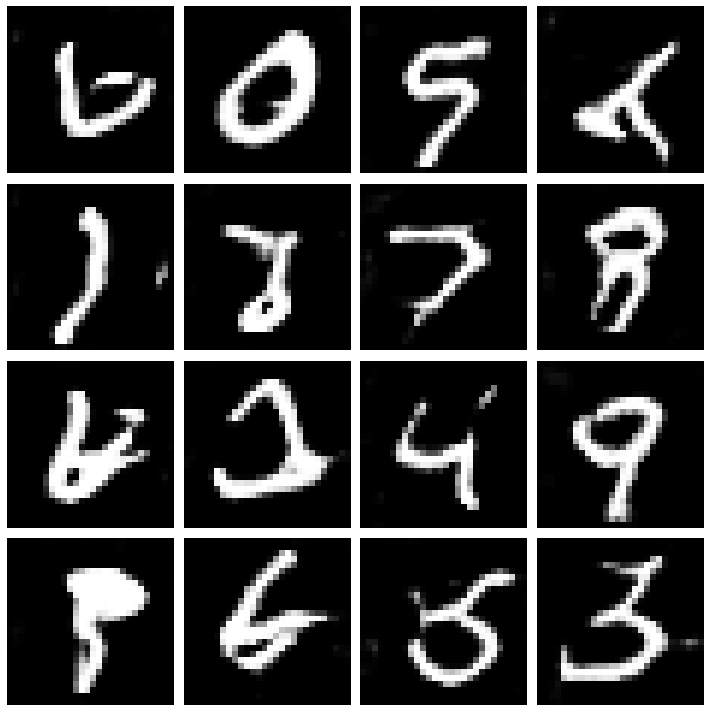

In [9]:
tmp_noise = np.random.randn(16 * latent_space).reshape(16,latent_space)

images = G.predict(tmp_noise)

plt.figure(figsize=(10,10))

for im in range(images.shape[0]):
    plt.subplot(4, 4, im+1)
    image = images[im, :, :, :]
    image = np.reshape(image, [28, 28])
            
    plt.imshow(image, cmap='gray')
    plt.axis('off')
        
plt.tight_layout()
plt.show()
#plt.savefig(f'output/mnist-d/{epoch}.png')
plt.close('all')


In [ ]:
'''
# Test on fashion-mist
# Load dataset
fashion_mnist, _ = load_dataset('Fashion-MNIST')

# Plot dataset element
plt.figure()
img = np.reshape(fashion_mnist[1], [28, 28])
plt.imshow(img, cmap='gray')
plt.show()

# Define latent space
latent_space = 100
in_shape = (fashion_mnist[0].shape[0], fashion_mnist[0].shape[1], 1)

print('Shape:', in_shape)

# Build Generator and Discriminator
D_f = build_discriminator(input_shape=in_shape)
G_f = build_generator(latent_dim=latent_space)

# Create DCGAN framework
GAN_f = build_gan(D_f, G_f, in_shape, latent_space)

# Train DCGAN
Df_l, Df_a_r, Df_a_f, Gf_l, Gf_a = train(D_f, G_f, GAN_f, fashion_mnist, latent_dim=latent_space)
'''

In [ ]:
test = []

for i in range(10):
    tmp_z = np.random.randn(latent_space).reshape(1,latent_space)

    gen = G_f.predict(tmp_z)
    test.append(D_f.predict(gen))
    print(test[i])
    plt.figure()
    img = np.reshape(gen, [28, 28])
    plt.imshow(img, cmap='gray')
    plt.show()
    


9360


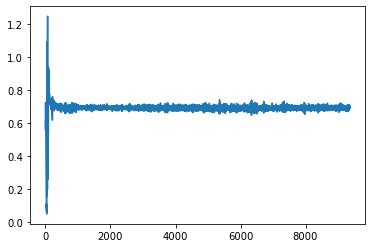

In [10]:
D_l = np.reshape(D_l, [len(D_l) * len(D_l[0])])
print(len(D_l))

plt.figure()
plt.plot(D_l)
plt.show()

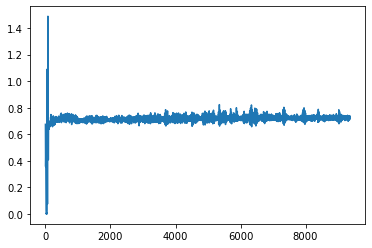

In [11]:
G_l = np.reshape(G_l, [len(G_l) * len(G_l[0])])
plt.figure()
plt.plot(G_l)
plt.show()


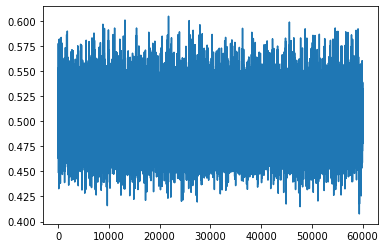

In [12]:
#y = np.ones((60000, 1))
training_acc = D.predict(trainX)

plt.figure()
plt.plot(training_acc)
plt.show()

In [13]:
print(training_acc.shape)

(60000, 1)


In [14]:
real = 0
fake = 0

for i in range(training_acc.shape[0]):
    if training_acc[i] >= 0.5:
        real += 1
    else:
        fake += 1

print('Training Accuracy: ', real/training_acc.shape[0])

Training Accuracy:  0.5329333333333334


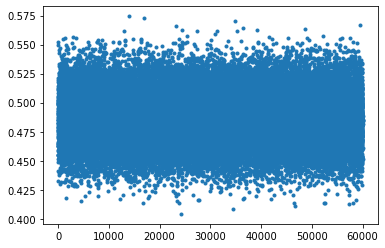

Generated Accuracy:  0.25566666666666665


In [15]:
# Random generate half_batch fake samples
fakeX, fakeY = gen_fake(G, latent_space, training_acc.shape[0])

gen_acc = D.predict(fakeX)

plt.figure()
plt.plot(gen_acc, '.')
plt.show()

real = 0
fake = 0

for i in range(training_acc.shape[0]):
    if gen_acc[i] >= 0.5:
        real += 1
    else:
        fake += 1

print('Generated Accuracy: ', real/training_acc.shape[0])

In [16]:

# at the end of your training, end the Comet experiment
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/kraing/gan/c733b9c7901c42839b98b1daf45a647e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc_d_fake [9360] : (0.0, 1.0)
COMET INFO:     acc_d_real [9360] : (0.171875, 1.0)
COMET INFO:     acc_g [9360]      : (0.03125, 1.0)
COMET INFO:     loss_d [9360]     : (0.0478312112390995, 1.2468746900558472)
COMET INFO:     loss_g [9360]     : (9.94604761217488e-06, 1.4884135723114014)
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (14 KB)
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (211 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO